In [1]:
from brian2 import *

In [2]:
%matplotlib inline

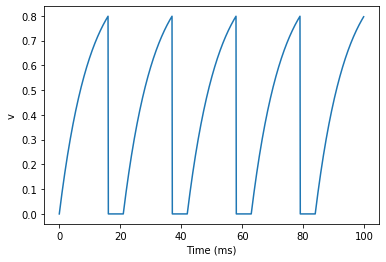

In [14]:
# Single neuron activity
# make sure the previous neurons are not active after this line
start_scope()

# define neuron membrane potential behavior (differential equation)
tau = 10*ms
eqs = '''
dv/dt = (1-v)/tau : 1 (unless refractory)
'''

# create neuron groups
# threshold: spike threshold
# reset: potential after spike
# refractory: time no spike will hapen after a spike (supress)
G = NeuronGroup(1, eqs, threshold='v>0.8', refractory=5*ms, reset='v = 0', method='exact')

# set data monitor
M = StateMonitor(G, 'v', record=True)

# run simulation
run(100*ms)

plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v');


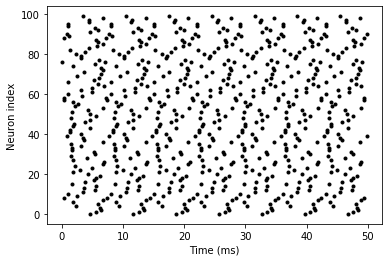

In [15]:
# Multiple neurons activity
start_scope()

N = 100
tau = 10*ms
eqs = '''
dv/dt = (2-v)/tau : 1
'''

G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', method='exact')
G.v = 'rand()'

spikemon = SpikeMonitor(G)

run(50*ms)

plot(spikemon.t/ms, spikemon.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');

WARNING    "tau" is an internal variable of group "neurongroup_2", but also exists in the run namespace with the value 10. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


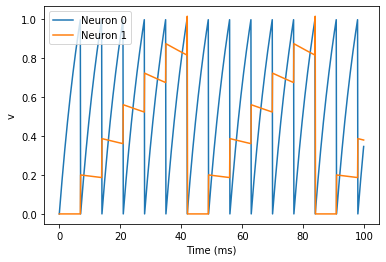

In [16]:
# Synapse
start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''

G = NeuronGroup(2, eqs, threshold='v>1', reset='v=0', method='exact')
G.I = [2, 0]
G.tau = [10, 100]*ms

S = Synapses(G, G, on_pre='v_post += 0.2')
S.connect(i=0, j=1)

M = StateMonitor(G, 'v', record=True)

run(100*ms)

plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
xlabel('Time (ms)')
ylabel('v')
legend();

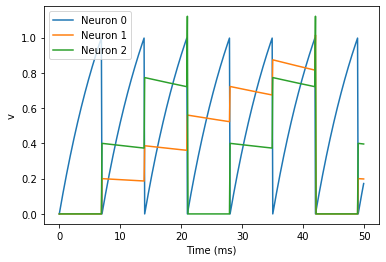

In [10]:
# with weight
start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = NeuronGroup(3, eqs, threshold='v>1', reset='v = 0', method='exact')
G.I = [2, 0, 0]
G.tau = [10, 100, 100]*ms

S = Synapses(G, G, 'w : 1', on_pre='v_post += w')
S.connect(i=0, j=[1, 2])
S.w = 'j*0.2'

M = StateMonitor(G, 'v', record=True)

run(50*ms)

plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
plot(M.t/ms, M.v[2], label='Neuron 2')
xlabel('Time (ms)')
ylabel('v')
legend();

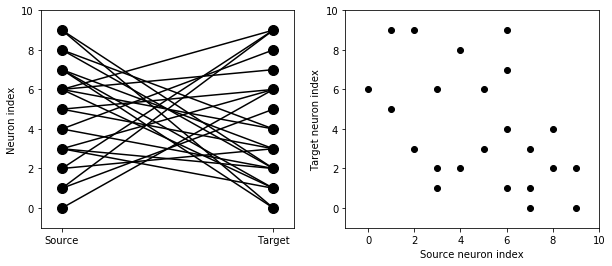

In [17]:
# Complex synapses
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')
S = Synapses(G, G)
S.connect(condition='i!=j', p=0.2)

def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')

visualise_connectivity(S)

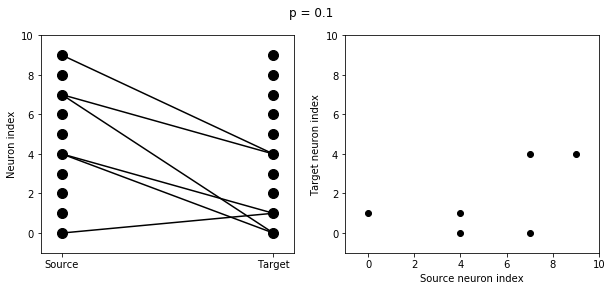

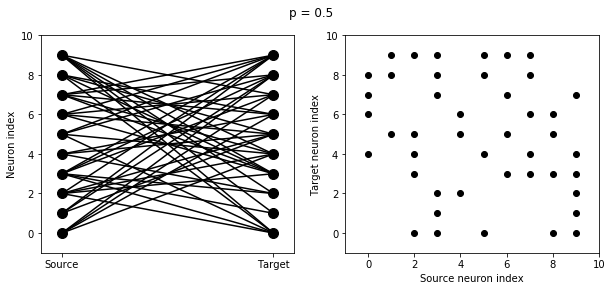

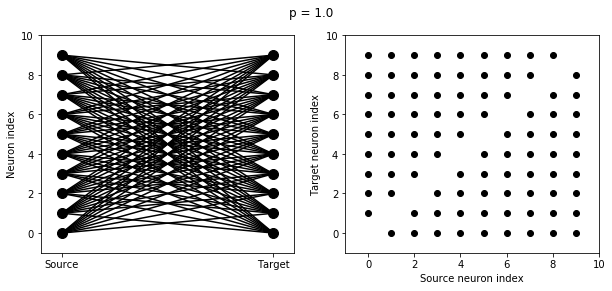

In [18]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')

for p in [0.1, 0.5, 1.0]:
    S = Synapses(G, G)
    S.connect(condition='i!=j', p=p)
    visualise_connectivity(S)
    suptitle('p = ' + str(p))

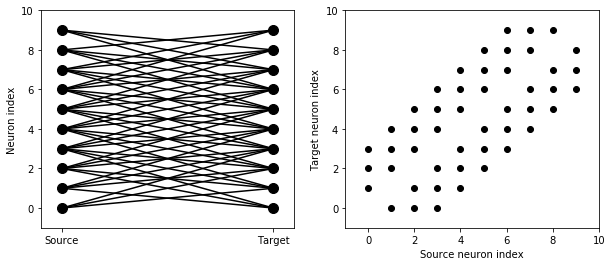

In [21]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')

S = Synapses(G, G)
S.connect(condition='abs(i-j)<4 and i!=j')
visualise_connectivity(S)

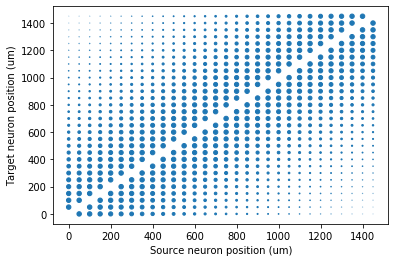

In [22]:
# Complex synapses with different weights
start_scope()

N = 30
neuron_spacing = 50 * umetre
width = N/4.0*neuron_spacing

G = NeuronGroup(N, 'x : metre')
G.x = 'i*neuron_spacing'

S = Synapses(G, G, 'w : 1')
S.connect(condition='i!=j')

S.w = 'exp(-(x_pre-x_post)**2/(2*width**2))'

scatter(S.x_pre/um, S.x_post/um, S.w*20)
xlabel('Source neuron position (um)')
ylabel('Target neuron position (um)');

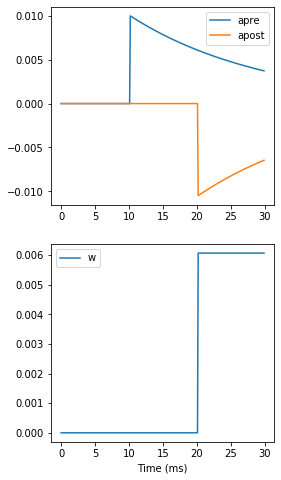

In [25]:
# STDP synapses
start_scope()

taupre = taupost = 20*ms
wmax = 0.01
Apre = 0.01
Apost = -Apre*taupre/taupost*1.05

G = NeuronGroup(2, 'v:1', threshold='t>(1+i)*10*ms', refractory=100*ms)

S = Synapses(G, G,
             '''
             w : 1
             dapre/dt = -apre/taupre : 1 (clock-driven)
             dapost/dt = -apost/taupost : 1 (clock-driven)
             ''',
             on_pre='''
             v_post += w
             apre += Apre
             w = clip(w+apost, 0, wmax)
             ''',
             on_post='''
             apost += Apost
             w = clip(w+apre, 0, wmax)
             ''', method='linear')
S.connect(i=0, j=1)
M = StateMonitor(S, ['w', 'apre', 'apost'], record=True)

run(30*ms)

figure(figsize=(4, 8))
subplot(211)
plot(M.t/ms, M.apre[0], label='apre')
plot(M.t/ms, M.apost[0], label='apost')
legend()
subplot(212)
plot(M.t/ms, M.w[0], label='w')
legend(loc='best')
xlabel('Time (ms)');

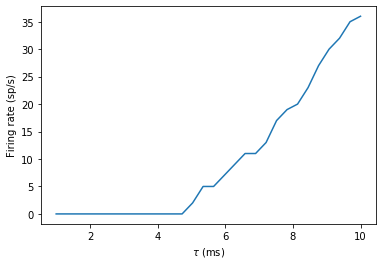

In [26]:
start_scope()
num_inputs = 100
input_rate = 10*Hz
weight = 0.1
tau_range = linspace(1, 10, 30)*ms
output_rates = []
# Construct the Poisson spikes just once
P = PoissonGroup(num_inputs, rates=input_rate)
MP = SpikeMonitor(P)
# We use a Network object because later on we don't
# want to include these objects
net = Network(P, MP)
net.run(1*second)
# And keep a copy of those spikes
spikes_i = MP.i
spikes_t = MP.t
# Now construct the network that we run each time
# SpikeGeneratorGroup gets the spikes that we created before
SGG = SpikeGeneratorGroup(num_inputs, spikes_i, spikes_t)
eqs = '''
dv/dt = -v/tau : 1
'''
G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
S = Synapses(SGG, G, on_pre='v += weight')
S.connect()
M = SpikeMonitor(G)
# Store the current state of the network
net = Network(SGG, G, S, M)
net.store()
for tau in tau_range:
    # Restore the original state of the network
    net.restore()
    # Run it with the new value of tau
    net.run(1*second)
    output_rates.append(M.num_spikes/second)
plot(tau_range/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)');

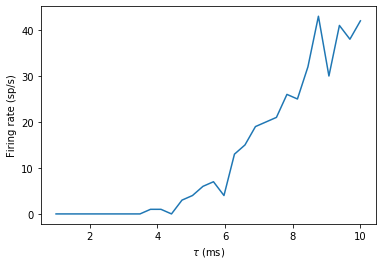

In [27]:
start_scope()
num_inputs = 100
input_rate = 10*Hz
weight = 0.1
tau_range = linspace(1, 10, 30)*ms
output_rates = []
# Construct the network just once
P = PoissonGroup(num_inputs, rates=input_rate)
eqs = '''
dv/dt = -v/tau : 1
'''
G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
S = Synapses(P, G, on_pre='v += weight')
S.connect()
M = SpikeMonitor(G)
# Store the current state of the network
store()
for tau in tau_range:
    # Restore the original state of the network
    restore()
    # Run it with the new value of tau
    run(1*second)
    output_rates.append(M.num_spikes/second)
plot(tau_range/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)');

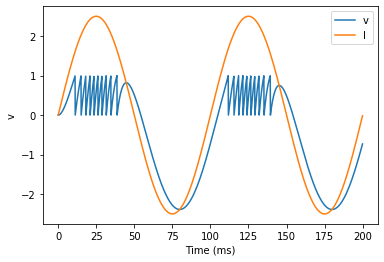

In [31]:
# with input

start_scope()
A = 2.5
f = 10*Hz
tau = 5*ms
eqs = '''
dv/dt = (I-v)/tau : 1
I = A*sin(2*pi*f*t) : 1
'''
G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='euler')
M = StateMonitor(G, variables=True, record=True)
run(200*ms)
plot(M.t/ms, M.v[0], label='v')
plot(M.t/ms, M.I[0], label='I')
xlabel('Time (ms)')
ylabel('v')
legend(loc='best');

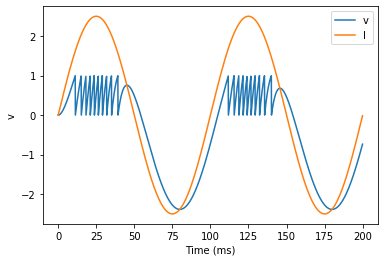

In [29]:
start_scope()
A = 2.5
f = 10*Hz
tau = 5*ms
# Create a TimedArray and set the equations to use it
t_recorded = arange(int(200*ms/defaultclock.dt))*defaultclock.dt
I_recorded = TimedArray(A*sin(2*pi*f*t_recorded), dt=defaultclock.dt)
eqs = '''
dv/dt = (I-v)/tau : 1
I = I_recorded(t) : 1
'''
G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
M = StateMonitor(G, variables=True, record=True)
run(200*ms)
plot(M.t/ms, M.v[0], label='v')
plot(M.t/ms, M.I[0], label='I')
xlabel('Time (ms)')
ylabel('v')
legend(loc='best');

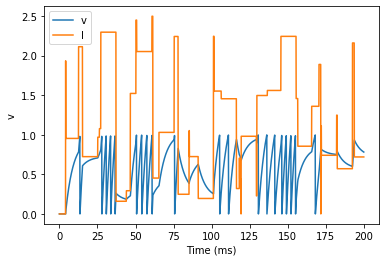

In [32]:
# random input

start_scope()
A = 2.5
f = 10*Hz
tau = 5*ms
# Let's create an array that couldn't be
# reproduced with a formula
num_samples = int(200*ms/defaultclock.dt)
I_arr = zeros(num_samples)
for _ in range(100):
    a = randint(num_samples)
    I_arr[a:a+100] = rand()
I_recorded = TimedArray(A*I_arr, dt=defaultclock.dt)
eqs = '''
dv/dt = (I-v)/tau : 1
I = I_recorded(t) : 1
'''
G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
M = StateMonitor(G, variables=True, record=True)
run(200*ms)
plot(M.t/ms, M.v[0], label='v')
plot(M.t/ms, M.I[0], label='I')
xlabel('Time (ms)')
ylabel('v')
legend(loc='best');